# Homework 3: optimization of a CNN model
The task of this homework is to optimize a CNN model for the CIFAR-100. You are free to define the architecture of the model, and the training procedure. The only contraints are:
- It must be a `torch.nn.Module` object
- The number of trained parameters must be less than 1 million
- The test dataset must not be used for any step of training. It is better if don't even import it.
- The final training notebook should run on Google Colab within a maximum 1 hour approximately.

For the grading, you must use the `evaluate` function defined below. It takes a model as input, and returns the test accuracy as output.

As a guideline, you are expected to **discuss** and motivate your choices regarding:
- Model architecture
- Hyperparameters (learning rate, batch size, etc)
- Regularization methods
- Optimizer
- Validation scheme

A code without any explanation of the choices will not be accepted. Test accuracy is not the only measure of success for this homework.

Remember that most of the train process is randomized, store your model's weights after training and load it before the evaluation!

## Example

### Loading packages and libraries

In [1]:
import torch
import torchvision
from evaluate import evaluate

# Import the best device available
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu')
print('Using device:', device)

# load the data
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())

100%|██████████| 169M/169M [00:13<00:00, 12.7MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Using device: cuda
Files already downloaded and verified


### Example of a simple CNN model

In [ ]:
class TinyNet(torch.nn.Module):
    def __init__(self):
        super(TinyNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(8*8*64, 128)
        self.fc2 = torch.nn.Linear(128, 100)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 8*8*64)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

print("Model parameters: ", sum(p.numel() for p in TinyNet().parameters()))

Model parameters:  556708


### Example of basic training

In [ ]:

model = TinyNet()
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
for epoch in range(10):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 10, loss.item()))


Epoch [1/10], Loss: 4.5927
Epoch [2/10], Loss: 4.5898
Epoch [3/10], Loss: 4.5984
Epoch [4/10], Loss: 4.5864
Epoch [5/10], Loss: 4.5467
Epoch [6/10], Loss: 4.5617
Epoch [7/10], Loss: 4.4748
Epoch [8/10], Loss: 4.2494
Epoch [9/10], Loss: 4.2803
Epoch [10/10], Loss: 3.9809


In [ ]:
# save the model on a file
torch.save(model.state_dict(), 'tiny_net.pt')

loaded_model = TinyNet()
loaded_model.load_state_dict(torch.load('tiny_net.pt', weights_only=True))
evaluate(loaded_model)

The model has 556708 parameters
Accuracy on the test set: 6.36%


- Res net
- bottleneck building block for deeper nets with fast training
- idenitity shortcut
- scheduler for learning rate. study if a plateau is present and in case reduce the lr at plateau
- weight initialization using kaming he initialization (works better than xavier)
- regularization using weight decay: no dropout becauase when using BN it can be avoided
- optimizer: sdg or adam

In [16]:
from typing import Optional
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
from training_utils import *
import numpy as np

In [3]:
DEVICE = None
if torch.cuda.is_available():
    # Requires NVIDIA GPU with CUDA installed
    DEVICE = torch.device("cuda")
elif torch.mps.is_available():
    # Requires Apple computer with M1 or later chip
    DEVICE = torch.device("mps")
else:
    # Not recommended, because it's slow. Move to Google Colab!
    DEVICE = torch.device("cpu")

print(DEVICE)

cuda


In [4]:
transform = torchvision.transforms.ToTensor()

BATCH_SIZE = 128

# load the train dataset
train_dataset = torchvision.datasets.CIFAR100(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# Split the dataset into 40k-10k samples for training-validation.
from torch.utils.data import random_split
train_dataset,  valid_dataset = random_split(
    train_dataset,
    lengths=[40000, 10000],
    generator=torch.Generator().manual_seed(42)
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2)

Files already downloaded and verified


I define a fit function as the one used in the tp

In [23]:
def fit(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    scheduler_lr: Optional[torch.optim.lr_scheduler._LRScheduler] = None,
    val_dataloader: Optional[DataLoader] = None
):
    """
    the fit method simply calls the train_epoch() method for a
    specified number of epochs.
    """

    # keep track of the losses in order to visualize them later
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Train
        train_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device,
        )
        train_losses.append(train_loss)
        # Validate
        if val_dataloader is not None:
            val_loss, val_accuracy = predict(
                model=model, test_dataloader=val_dataloader, device=device, verbose=False
            )
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            print(
                f"Epoch {epoch}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.0f}%"
            )
        else:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}")
        # LR scheduler
        if scheduler_lr is not None:
            scheduler_lr.step(metrics=val_loss)

    return train_losses, val_losses, val_accuracies

The architecture I choose is a ResNet. ResNets as we have seen in class are very good network to perform image classification tasks.
The one I choose is a residual block ResNEt with a skip connection.
 Skip connection is important because it allows to have deep networks, which offer better performance, without the problem of the vanishing gradient.

I define the residual block of the ResNet.
My block is a 3-layer block with a bottleneck. I choose this structure because it allows to hava e deep network but still with manageble training times.
Each layer is made up of a convolution, a batch normalization and a ReLu used as activation function, in this order.
The three covolutions used are the following:
- 1x1 convolution layer to reduce dimensions
- 3x3 (bottleneck) convolution layer on the reduced dimension
- 1x1 convolution to restore the dimension

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels=in_planes,
            out_channels=planes,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(
            in_channels=planes,
            out_channels=planes,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        # Skip connection to match dimensions when necessary
        self.skip = nn.Sequential()
        if stride > 1 or in_planes != planes:
            self.skip = nn.Sequential(
                nn.Conv2d(
                    in_channels=in_planes,
                    out_channels=planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out += self.skip(x)
        out = F.relu(out)
        return out

Now I write the network.

In [11]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super().__init__()
        self.in_planes = 16  # Initial number of filters

        # First layer: 3x3 Convolution
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        # Residual layers
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)

        # Global Average Pooling and Fully Connected Layer
        self.linear = nn.Linear(self.in_planes, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                torch.nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        if out.size(2) > 1 and out.size(3) > 1:
          out = F.avg_pool2d(out, out.size(3))  # Global Average Pooling only if size is >1
        else:
          out = F.adaptive_avg_pool2d(out, (1, 1))  # fallback to adaptive avg pooling if size is too small

        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

print("Model parameters: ", sum(p.numel() for p in ResNet(block=ResidualBlock, num_blocks=[12,11,10]).parameters()))



Model parameters:  986740


In [14]:
%env CUDA_LAUNCH_BLOCKING=1

model = ResNet(block=ResidualBlock, num_blocks=[12, 11, 10]).to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001, momentum=0.9)
scheduler_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3)

train_losses, valid_losses, valid_accs =   fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 50,
        device = DEVICE,
        val_dataloader = valid_dataloader,
        scheduler_lr = scheduler_lr
    )
plot_loss( train_losses )


env: CUDA_LAUNCH_BLOCKING=1
ciao
Epoch 0: Train Loss=4.3782, Val Loss=4.3132, Val Accuracy=6%
Epoch 1: Train Loss=3.8137, Val Loss=3.6865, Val Accuracy=12%
Epoch 2: Train Loss=3.5255, Val Loss=3.4498, Val Accuracy=18%
Epoch 3: Train Loss=3.2766, Val Loss=3.3265, Val Accuracy=19%
Epoch 4: Train Loss=3.0513, Val Loss=3.2310, Val Accuracy=21%
Epoch 5: Train Loss=2.8521, Val Loss=3.0197, Val Accuracy=26%
Epoch 6: Train Loss=2.6604, Val Loss=2.8331, Val Accuracy=28%
Epoch 7: Train Loss=2.4892, Val Loss=2.8923, Val Accuracy=28%
Epoch 8: Train Loss=2.3442, Val Loss=2.7516, Val Accuracy=31%
Epoch 9: Train Loss=2.1924, Val Loss=2.7218, Val Accuracy=32%
Epoch 10: Train Loss=2.0816, Val Loss=2.5503, Val Accuracy=35%
Epoch 11: Train Loss=1.9625, Val Loss=2.6076, Val Accuracy=35%
Epoch 12: Train Loss=1.8510, Val Loss=2.5149, Val Accuracy=36%
Epoch 13: Train Loss=1.7639, Val Loss=2.4840, Val Accuracy=37%
Epoch 14: Train Loss=1.6715, Val Loss=2.5155, Val Accuracy=36%
Epoch 15: Train Loss=1.5934, Val 

KeyboardInterrupt: 

In [28]:
# Perform per pixel noramlization

mean = [0.5071, 0.4865, 0.4409]
std =  [0.2673, 0.2564, 0.2762]

# Define a new transform with data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Random crop with padding
    transforms.RandomHorizontalFlip(),    # Randomly flip images horizontally
    transforms.RandomRotation(15),       # Randomly rotate images
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)  # Normalize to CIFAR-100 stats
])

# No data augmentation for validation
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Fetch data and apply the new transformer
BATCH_SIZE = 128

# load the train dataset
augmented_dataset = torchvision.datasets.CIFAR100(
    root='./data/',
    train=True,
    download=True,
    transform=train_transform)

base_dataset = torchvision.datasets.CIFAR100(
    root='./data/',
    train=True,
    download=True,
    transform=val_transform)

# Split both the augmented and not augmented dataset,
# but take the training from the augmented and the validation from the not augmented

from torch.utils.data import random_split
train_dataset, _ = random_split(
    augmented_dataset,
    lengths=[40000, 10000],
    generator=torch.Generator().manual_seed(42)
)

_, valid_dataset = random_split(
    base_dataset,
    lengths=[40000, 10000],
    generator=torch.Generator().manual_seed(42)
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


env: CUDA_LAUNCH_BLOCKING=1
Epoch 0: Train Loss=4.5288, Val Loss=4.1722, Val Accuracy=6%
Epoch 1: Train Loss=4.0776, Val Loss=3.9021, Val Accuracy=10%
Epoch 2: Train Loss=3.8517, Val Loss=3.6313, Val Accuracy=14%
Epoch 3: Train Loss=3.6666, Val Loss=3.5116, Val Accuracy=16%
Epoch 4: Train Loss=3.5054, Val Loss=3.4877, Val Accuracy=18%
Epoch 5: Train Loss=3.3484, Val Loss=3.3403, Val Accuracy=20%
Epoch 6: Train Loss=3.1949, Val Loss=3.2249, Val Accuracy=22%
Epoch 7: Train Loss=3.0449, Val Loss=2.9543, Val Accuracy=26%
Epoch 8: Train Loss=2.9118, Val Loss=3.0402, Val Accuracy=26%
Epoch 9: Train Loss=2.8003, Val Loss=2.6784, Val Accuracy=32%
Epoch 10: Train Loss=2.6824, Val Loss=3.0944, Val Accuracy=27%
Epoch 11: Train Loss=2.5988, Val Loss=2.6274, Val Accuracy=32%
Epoch 12: Train Loss=2.5055, Val Loss=2.5529, Val Accuracy=34%
Epoch 13: Train Loss=2.4159, Val Loss=2.4331, Val Accuracy=37%
Epoch 14: Train Loss=2.3516, Val Loss=2.3151, Val Accuracy=39%
Epoch 15: Train Loss=2.2701, Val Loss=

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7860fcbdab90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7860fcbdab90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

Epoch 17: Train Loss=2.1608, Val Loss=2.1915, Val Accuracy=42%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7860fcbdab90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7860fcbdab90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 18: Train Loss=2.1004, Val Loss=2.2316, Val Accuracy=41%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7860fcbdab90>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7860fcbdab90>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

    self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process  File "/usr/lib/p

Epoch 19: Train Loss=2.0496, Val Loss=2.2578, Val Accuracy=42%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7860fcbdab90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7860fcbdab90><function _MultiProcessingDataLoaderIter.__del__ at 0x7860fcbdab90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/d

Epoch 20: Train Loss=2.0130, Val Loss=2.1170, Val Accuracy=45%
Epoch 21: Train Loss=1.9643, Val Loss=2.0353, Val Accuracy=46%
Epoch 22: Train Loss=1.9232, Val Loss=2.0889, Val Accuracy=45%
Epoch 23: Train Loss=1.8879, Val Loss=2.2628, Val Accuracy=42%
Epoch 24: Train Loss=1.8553, Val Loss=2.0168, Val Accuracy=46%
Epoch 25: Train Loss=1.8182, Val Loss=1.9938, Val Accuracy=46%
Epoch 26: Train Loss=1.7982, Val Loss=2.0302, Val Accuracy=47%
Epoch 27: Train Loss=1.7675, Val Loss=2.0095, Val Accuracy=46%
Epoch 28: Train Loss=1.7268, Val Loss=1.8843, Val Accuracy=50%
Epoch 29: Train Loss=1.7108, Val Loss=1.9463, Val Accuracy=48%
Epoch 30: Train Loss=1.6855, Val Loss=1.8855, Val Accuracy=50%
Epoch 31: Train Loss=1.6553, Val Loss=1.9016, Val Accuracy=49%
Epoch 32: Train Loss=1.6460, Val Loss=1.8724, Val Accuracy=50%
Epoch 33: Train Loss=1.6193, Val Loss=1.7996, Val Accuracy=51%
Epoch 34: Train Loss=1.5975, Val Loss=1.8750, Val Accuracy=50%
Epoch 35: Train Loss=1.5828, Val Loss=1.9039, Val Accur

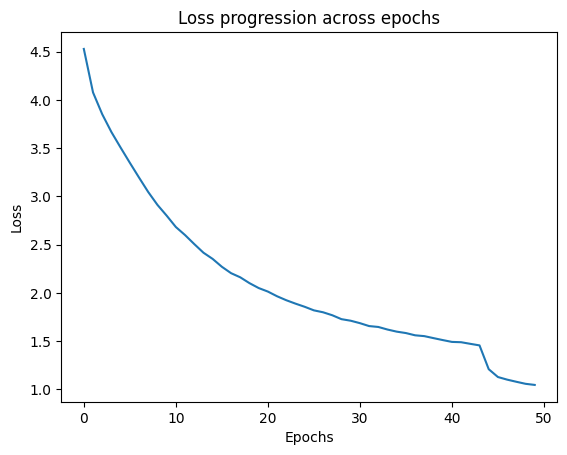

In [29]:
%env CUDA_LAUNCH_BLOCKING=1

model = ResNet(block=ResidualBlock, num_blocks=[12, 11, 10]).to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001, momentum=0.9)
scheduler_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3)

train_losses, valid_losses, valid_accs =   fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 50,
        device = DEVICE,
        val_dataloader = valid_dataloader,
        scheduler_lr = scheduler_lr
    )
plot_loss( train_losses )

- Try to change regularization parameter
- Try SGD optmizier with momentum
- Remove the per pixel mean before feeding the images into the network
- Retry the bottleneck architecture.